[ASSIGNMENT LINK](https://cliffdotai.notion.site/Machine-Learning-Engineer-Assignment-9b0ab76684b94ad6accc57307d4ceef5)

#TO-DO LIST
- forecast plots of each time-series, something similar to this.
- MAE, MSE, RMSE, MAPE
- An overview of their understanding of RIVIN. how and why it works.
- Choice of hyperparameters (backcast length, forecast length, training methodology etc), and the reason for the choice.

#Useful Resources
[ReVin Paper](https://openreview.net/pdf?id=cGDAkQo1C0p) |
[Nbeats Paper](https://arxiv.org/pdf/1905.10437.pdf) 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # trying with seasonality as 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrices
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [ ]:
def make_preds(model, input_data):
  """
  Parameters
  ---------- 
  input_data: windowed input data
  returns predictions.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Add windowed columns
def dataprep(df,WINDOW_SIZE):
  df_nbeats = df.copy()
  for i in range(WINDOW_SIZE):
    df_nbeats[f"value+{i+1}"] = df_nbeats["value"].shift(periods=i+1)
  df_nbeats.dropna()

  # Make features and labels
  X = df_nbeats.dropna().drop("value", axis=1)
  y = df_nbeats.dropna()["value"]

  # Make train and test sets
  split_size = int(len(X) * 0.75)
  X_train, y_train = X[:split_size], y[:split_size]
  X_test, y_test = X[split_size:], y[split_size:]
  len(X_train), len(y_train), len(X_test), len(y_test)


  # 1. Turn train and test arrays into tensor Datasets
  train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
  train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

  test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
  test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

  # 2. Combine features & labels
  train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
  test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

  # 3. Batch and prefetch for optimal performance
  BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
  train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset,test_dataset,y_train,y_test

##USING NBEATS

In [ ]:
# Create NBeatsBlock
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")


  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

#DATA PREPROCESSING
[Data Link (uploaded on google drive)](https://drive.google.com/drive/folders/1kmuXJUMEHDX9hUSCVJ5Q2c34YHYU-C47)

In [ ]:
# import the dataset
filename = 0
df = pd.read_csv("/content/drive/MyDrive/gtmhub/dataset50/"+str(filename)+".csv", parse_dates = ['timestamp'], index_col = 'timestamp')
# sort by dates
df.sort_index(inplace = True)
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
#PARAMS
HORIZON = 1
WINDOW_SIZE = 7

# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4 # called "block layers" in Table 18
N_STACKS = 30 # called "stacks" in Table 18

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
%%time

tf.random.set_seed(42)

# 0. prepare the data
train_dataset,test_dataset,y_train,y_test = dataprep(df,WINDOW_SIZE)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")
# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

# Add in subtraction residual layer
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in step 3

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put model stack together
nbeats_model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")
# 8. Compile:- loss:MAE, Optimizer:ADAM, LR:0.001
nbeats_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
nbeats_model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 160: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 293: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2335: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2438: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2538: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
CPU times: user 4min 4s, sys: 14 s, total: 4min 18s
Wall time: 4min 21s


In [ ]:
#evaluation
nbeats_model.evaluate(test_dataset)

1/1 [==============================] - 0s 20ms/step - loss: 0.0119 - mae: 0.0119 - mse: 2.4071e-04


[0.011942192912101746, 0.011942192912101746, 0.00024070915242191404]

In [ ]:
#predictions
nbeats_model_preds = make_preds(nbeats_model, test_dataset)
nbeats_model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47.79319 , 47.801605, 47.816017, 47.827244, 47.83223 , 47.833504,
       47.82948 , 47.827118, 47.82371 , 47.824875], dtype=float32)>

In [ ]:
#metrices results
nbeats_model_results = evaluate_preds(y_true=y_test,
                                 y_pred=nbeats_model_preds)
# for i,j in nbeats_model_results.items():
#   score.append(i+' '+str(j))

In [ ]:
# Plot the created N-BEATS model 
# from tensorflow.keras.utils import plot_model
# plot_model(nbeats_model)

#PLOTTING THE RESULTS

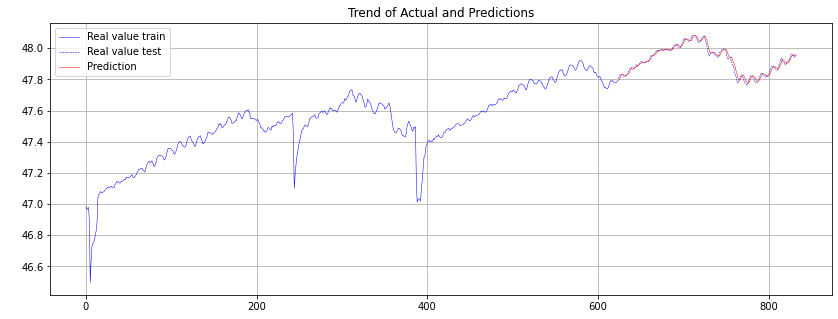

In [ ]:
preds = pd.DataFrame(index = np.arange(len(y_train) + len(y_test)))
preds['Real Value'] = np.hstack([y_train,y_test])
preds['Prediction'] = np.hstack([y_train,nbeats_model_preds])
# and plot the predictions
plt.figure(figsize=(14,5))
plt.ylabel(' ')
plt.title('Trend of Actual and Predictions')
plt.plot(preds['Real Value'][:int(len(preds['Prediction'])*0.75)],color ='blue',linewidth=0.5)
plt.plot(preds['Real Value'][int(len(preds['Prediction'])*0.75):],color ='blue',linestyle='dashed',linewidth=0.5)
plt.plot(preds['Prediction'][int(len(preds['Prediction'])*0.75):],color='red',linewidth=0.5)
# plt.axvline(x=int(len(preds['Prediction'])*0.75),color='brown',linestyle='dashed')
plt.legend(['Real value train','Real value test','Prediction'])
plt.grid(True)
plt.savefig("/content/drive/MyDrive/gtmhub/plots/"+str(filename)+'.png')

In [ ]:
preds['Prediction'][int(len(preds['Prediction'])*0.75):]

624    28.464479
625    28.469767
626    28.469763
627    28.468346
628    28.470098
         ...    
828    28.534407
829    28.535225
830    28.535160
831    28.536133
832    28.539591
Name: Prediction, Length: 209, dtype: float64

##USING REVIN NORMALISATION WITH NBEATS

In [ ]:
import tensorflow.keras.backend as K
class RevIN(layers.Layer):
    """
    Parameters
    ----------
    eps: float, a value added for numerical stability, default 1e-5.
    affine: bool, if True(default), RevIN has learnable affine parameters.
    """
    def __init__(self, eps=1e-5, affine=True, **kwargs):
        super(RevIN, self).__init__(**kwargs)
        self.eps = eps
        self.affine = affine

    def build(self, input_shape):
        self.affine_weight = self.add_weight(name='affine_weight',
                                 shape=(1, input_shape[-1]),
                                 initializer='ones',
                                 trainable=True)

        self.affine_bias = self.add_weight(name='affine_bias',
                                 shape=(1, input_shape[-1]),
                                 initializer='zeros',
                                 trainable=True)
        super(RevIN, self).build(input_shape)

    def forward(self, inputs, **kwargs):
        mode = kwargs.get('mode', None)
        if mode == 'norm':
            self._get_statistics(inputs)
            x = self._normalize(inputs)
        elif mode == 'denorm':
            x = self._denormalize(inputs)
        else:
            raise NotImplementedError('Only norm and denorm modes are valid.')
        return x

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, len(x.shape) - 1))
        self.mean = K.mean(x, axis=dim2reduce, keepdims=True)
        self.stdev = K.sqrt(K.var(x, axis=dim2reduce, keepdims=True) + self.eps)

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

    def get_config(self):
        config = {'eps': self.eps,
                  'affine': self.affine}
        base_config = super(RevIN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [ ]:
"""ALL OF THE STEPS ARE SAME AS BEFORE 
  EXCEPT STATEMENTS WITH ADDED COMMENTS"""
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               useRevIN=False,#extra parameter useRevIN is added which is False by default
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    if useRevIN==True: 
      revinlayer = RevIN() #declaring revin layer

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")


  def call(self, inputs): 
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
"""ALL OF THE STEPS ARE SAME AS BEFORE 
  EXCEPT STATEMENTS WITH ADDED COMMENTS"""
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               useRevIN=False,#extra parameter useRevIN is added which is False by default
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    if useRevIN==True: 
      revinlayer = RevIN() #declaring revin layer

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")


  def call(self, inputs): 
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
# import the dataset
filename=1
df = pd.read_csv("/content/drive/MyDrive/gtmhub/dataset50/"+str(filename)+".csv", parse_dates = ['timestamp'], index_col = 'timestamp')
# sort by dates
df.sort_index(inplace = True)
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
#PARAMS
HORIZON = 1
WINDOW_SIZE = 7

# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4 # called "block layers" in Table 18
N_STACKS = 30 # called "stacks" in Table 18

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
%%time
revinlayer = RevIN()
tf.random.set_seed(42)
train_dataset,test_dataset,y_train,y_test = dataprep(df,WINDOW_SIZE)

useRevIN=True
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 useRevIN=useRevIN,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

if useRevIN==True:
  residuals = revinlayer(residuals, mode='norm') #residualts will be normalised using revin layer

for i, _ in enumerate(range(N_STACKS-1)): 

  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 
  if useRevIN==True:
    residuals = revinlayer(residuals, mode='denorm') #denormalising the residuals with revin

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

nbeats_revin_model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS_revin")

nbeats_revin_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

nbeats_revin_model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [ ]:
nbeats_revin_model.evaluate(test_dataset)

1/1 [==============================] - 0s 469ms/step - loss: 0.0101 - mae: 0.0101 - mse: 1.5436e-04


[0.010106237605214119, 0.010106237605214119, 0.00015435520617756993]

In [ ]:
nbeats_revin_model_preds = make_preds(nbeats_revin_model, test_dataset)

In [ ]:
nbeats_revin_model_results = evaluate_preds(y_true=y_test,
                                 y_pred=nbeats_revin_model_preds)
# nbeats_revin_model_results
# for i,j in nbeats_revin_model_results.items():
#   score.append(i+" "+str(j))

In [ ]:
preds = pd.DataFrame(index = np.arange(len(y_train) + len(y_test)))
preds['Real Value'] = np.hstack([y_train,y_test])
preds['Prediction'] = np.hstack([y_train,nbeats_revin_model_preds])
plt.figure(figsize=(17,4))
plt.ylabel(' ')
plt.title('Trend of Actual and Predictions')
plt.plot(preds[['Real Value','Prediction']])
plt.legend(['Real value','Prediction'])
plt.grid(True)
plt.savefig("/content/drive/MyDrive/gtmhub/plots/"+str(filename)+'.png')

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(nbeats_revin_model)

#FOR MULTIPLE CSV FILES

# NBEATS + REVIN

In [ ]:
#PARAMS
HORIZON = 1
WINDOW_SIZE = 7

# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4 # called "block layers" in Table 18
N_STACKS = 30 # called "stacks" in Table 18

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON


Epoch 169: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 294: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1213: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1315: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1415: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
1/1 [==============================] - 0s 22ms/step - loss: 0.0096 - mae: 0.0096 - mse: 1.5109e-04
{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842']}
0 Done!!!

Epoch 301: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 429: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 544: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 644: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
1/1 [==============================] - 0s 21ms/step - loss: 0.0102 - mae: 0.0102 

{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791']}
3 Done!!!

Epoch 101: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 201: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0']}
4 Done!!!

Epoch 464: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1147: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1247: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1/1 [==============================] - 0s 20ms/step - loss: 0.0150 - mae: 0.0150 - mse: 4.2254e-04
{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'0': ['mae:0.009589638', 'mse:0.00015109031', 'rmse:0.012291879', 'mape:0.020012842'], '1': ['mae:0.010153583', 'mse:0.00015561783', 'rmse:0.012474688', 'mape:0.035632808'], '2': ['mae:0.055814788', 'mse:0.06711902', 'rmse:0.25907338', 'mape:0.12775685'], '3': ['mae:27.348204', 'mse:1978.1044', 'rmse:44.475883', 'mape:0.79791'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015046765', 'mse:0.00042254422', 'rmse:0.02055588', 'mape:0.35956115'], '6': ['mae:5599307000.0', 'mse:1.2895319e+21', 'rmse:35910054000.0', 'mape:38980816.0'], '7': ['mae:148.6449', 'mse:42232.02', 'rmse:205.5043', 'mape:10.698707'], '8': ['mae:279.65533', 'mse:203602.2', 'rmse:451.223', 'mape:5.478514'], '9': ['mae:732.0327', 'mse:1149655.6', 'rmse:1072.22', 'mape:10.845366'], '10': ['mae:0.07825913', 'mse:0.015455679', 'rmse:0.12432087', 'mape:1.1381618'], '11': ['mae:0.025426226', 'mse:0.0011970985', 'rmse:0.03459911', 'mape:0.28318155'], '12': ['mae:815.2981', 'mse:1644912.9', 'rmse:1282.54

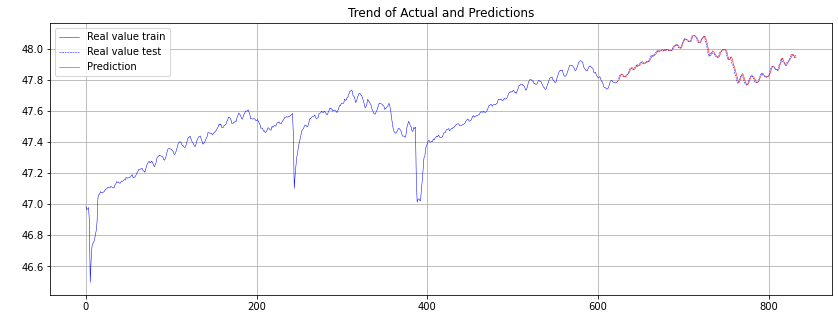

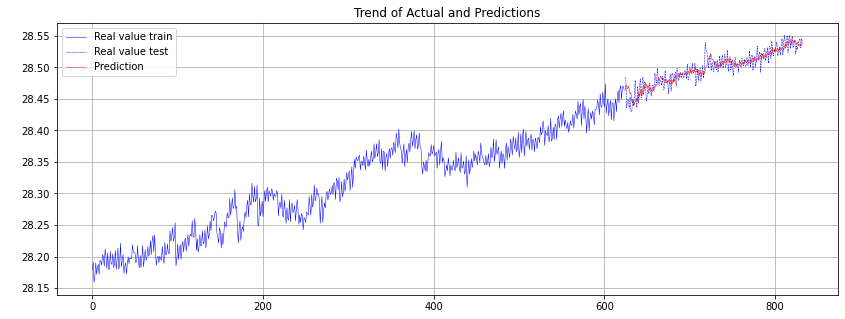

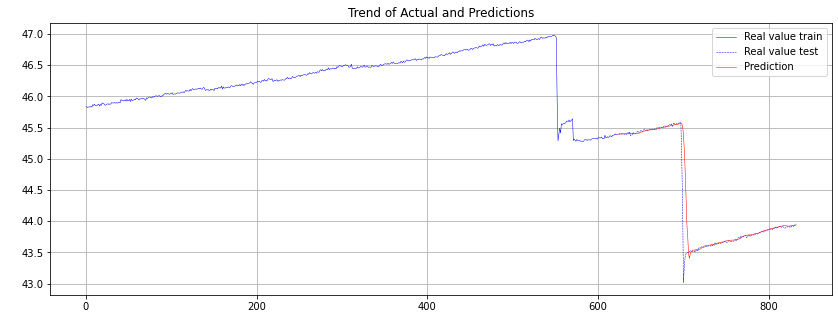

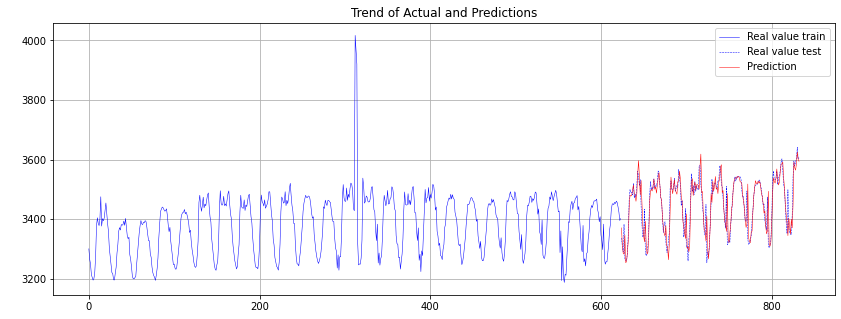

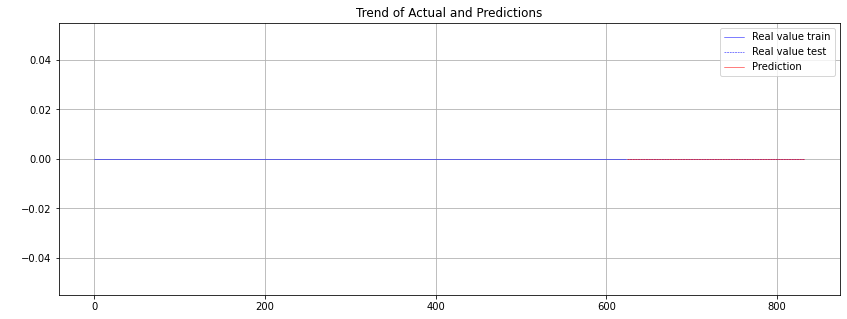

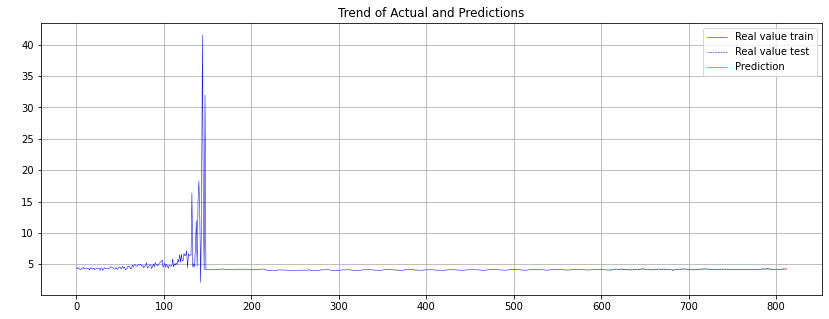

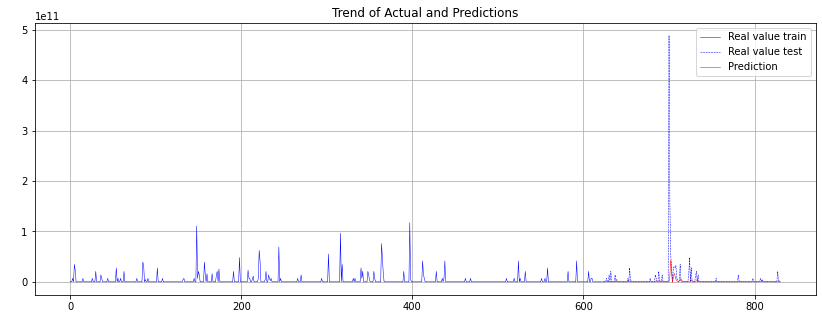

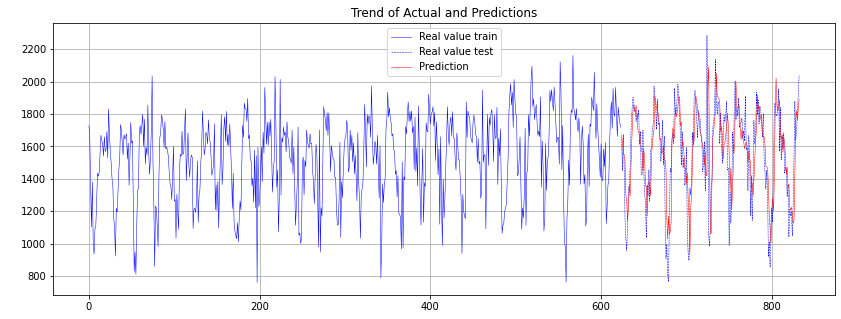

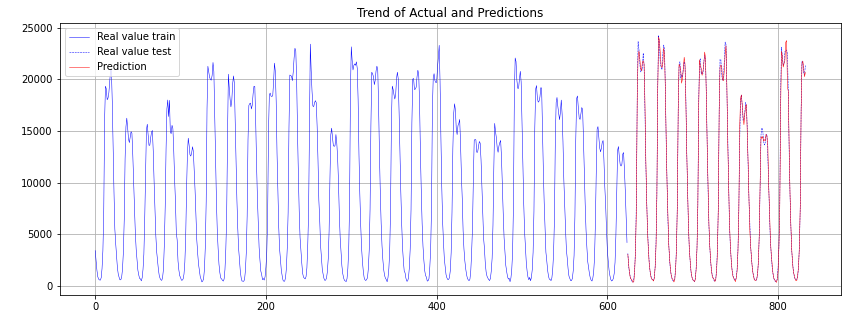

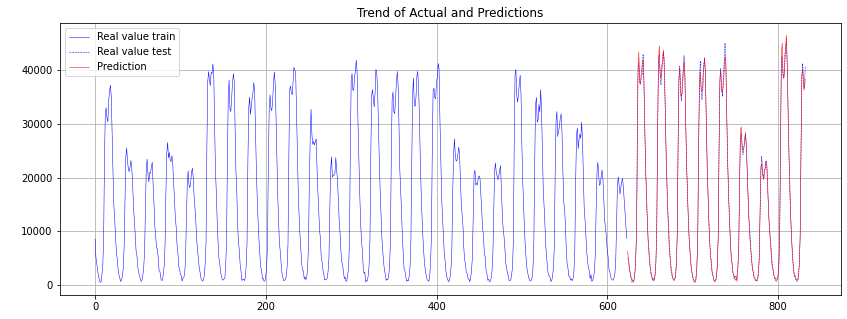

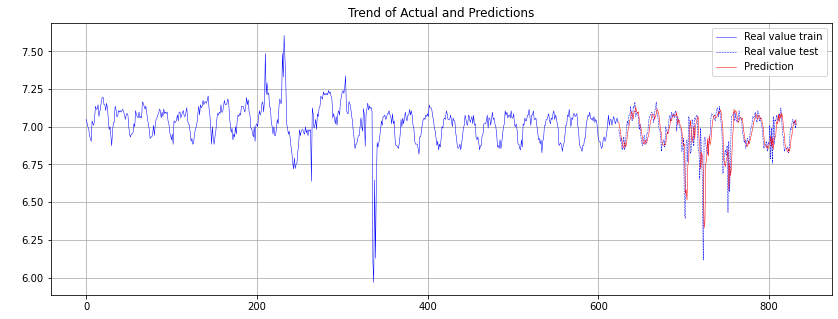

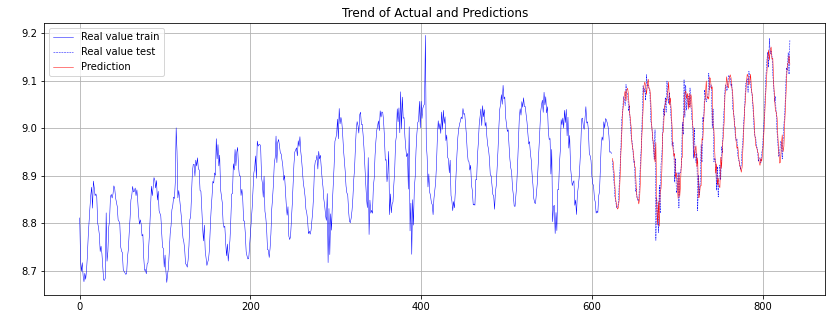

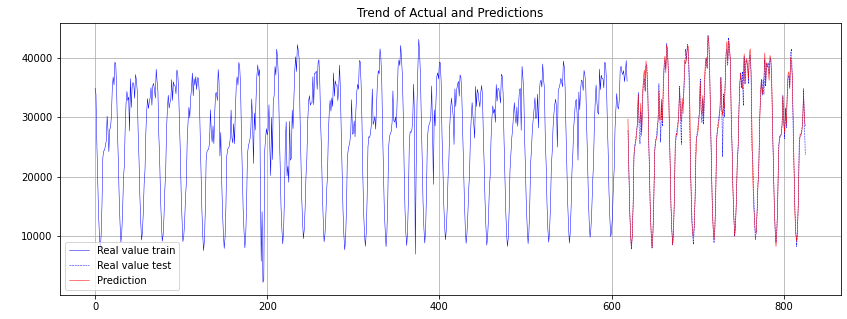

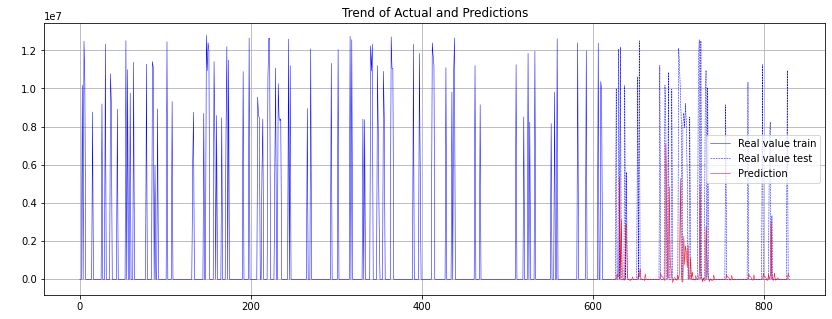

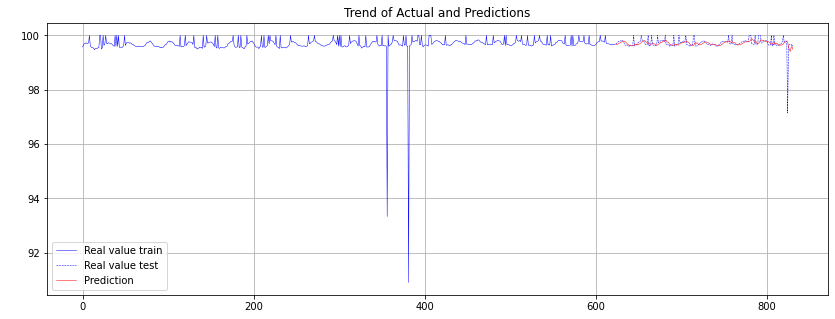

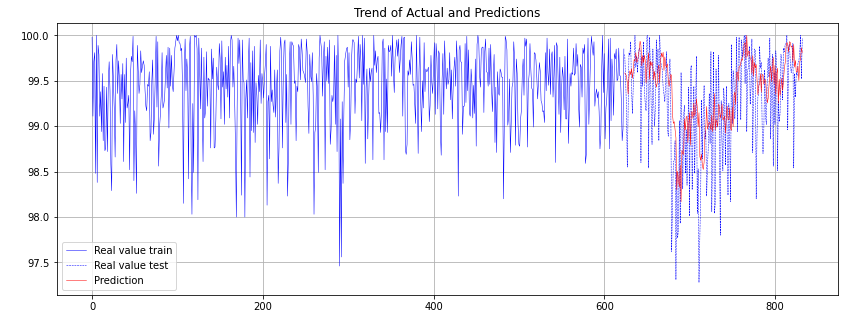

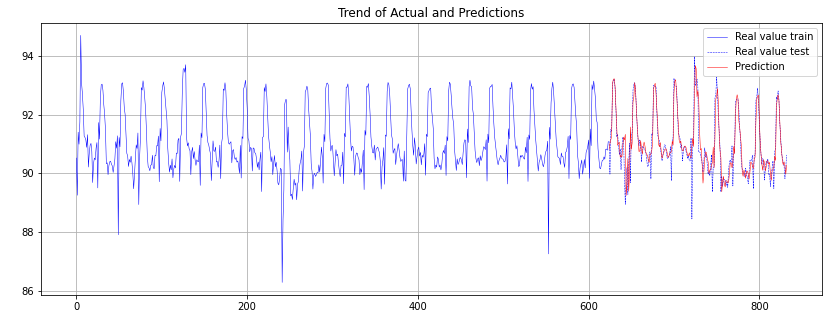

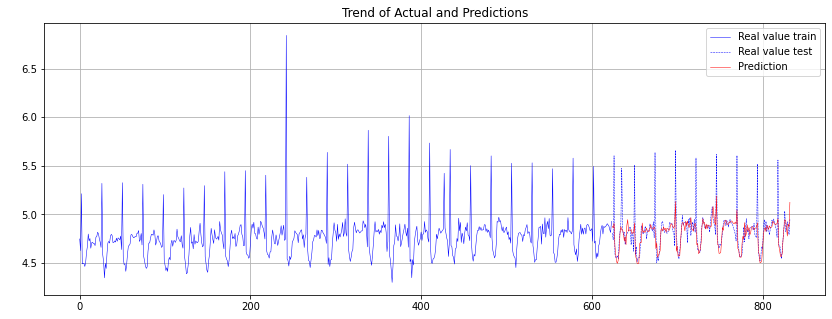

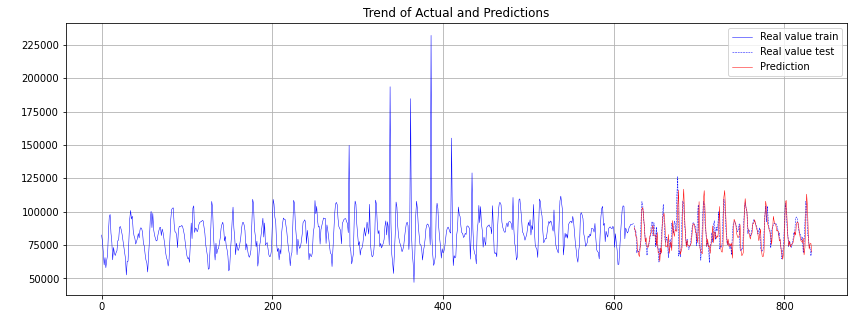

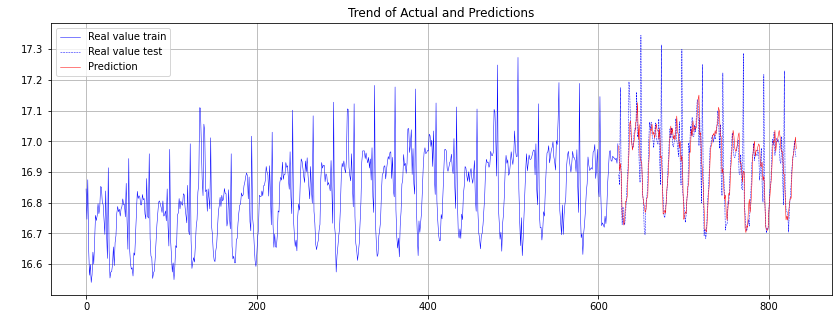

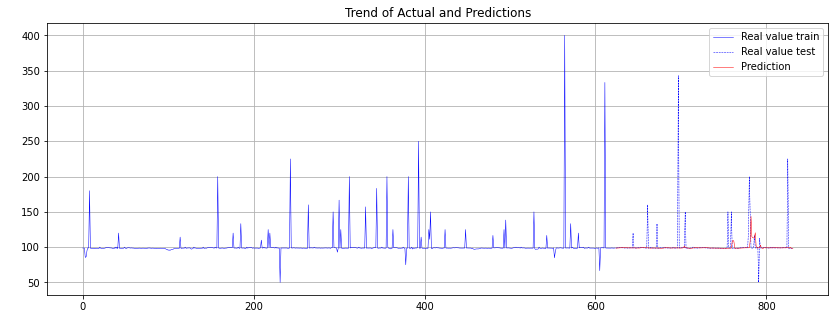

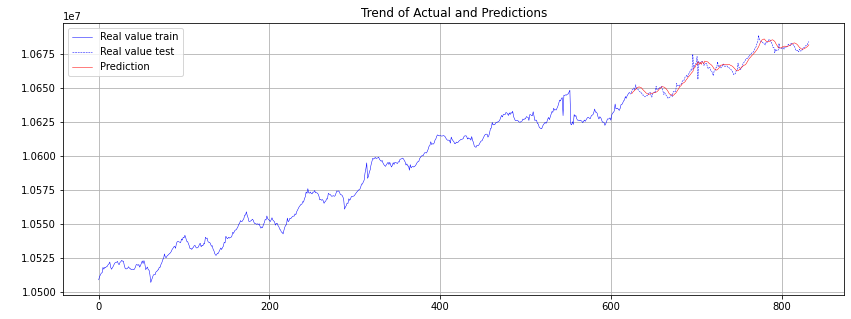

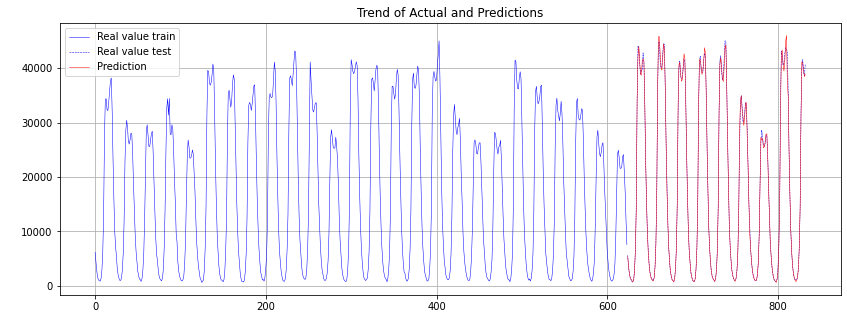

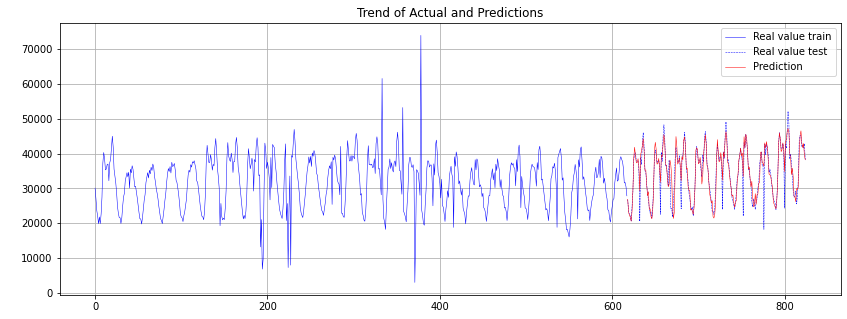

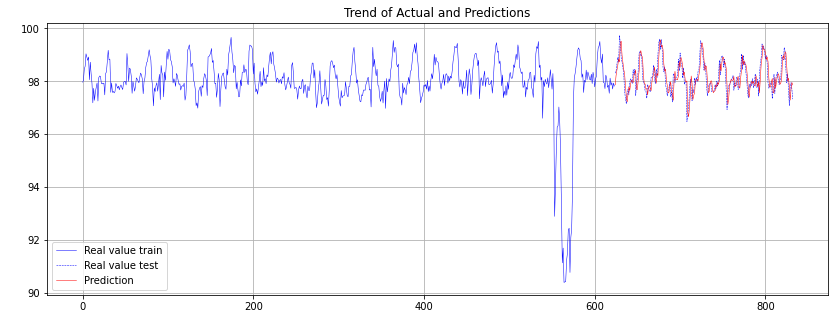

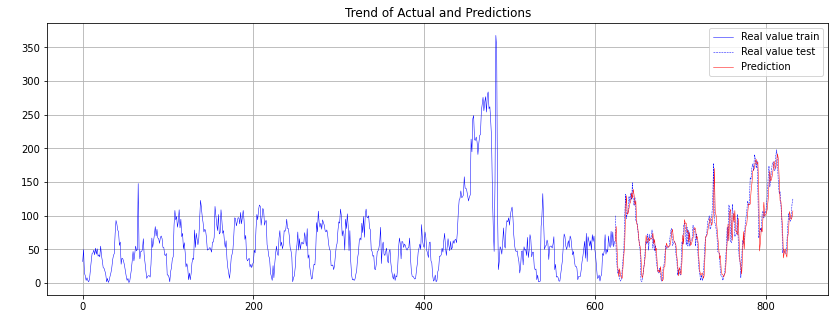

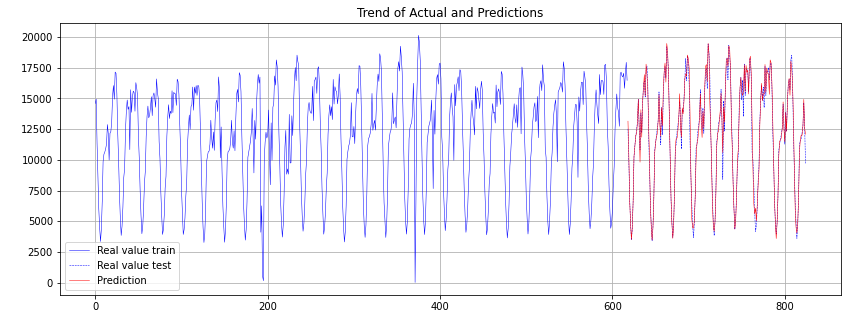

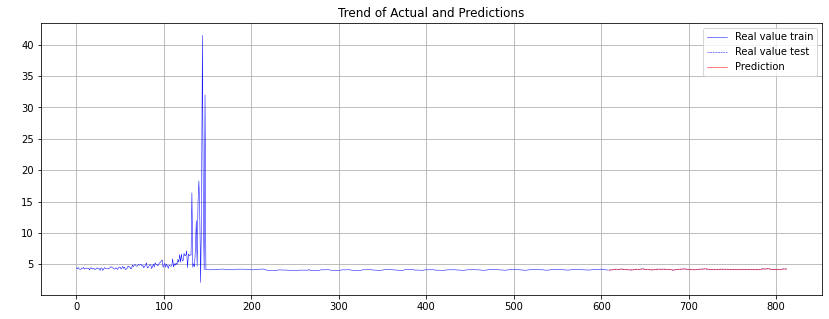

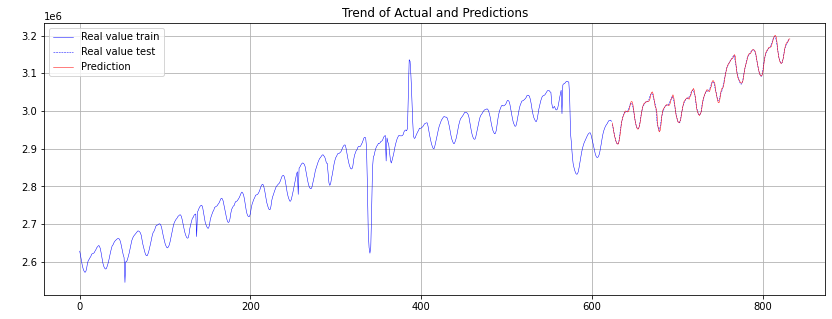

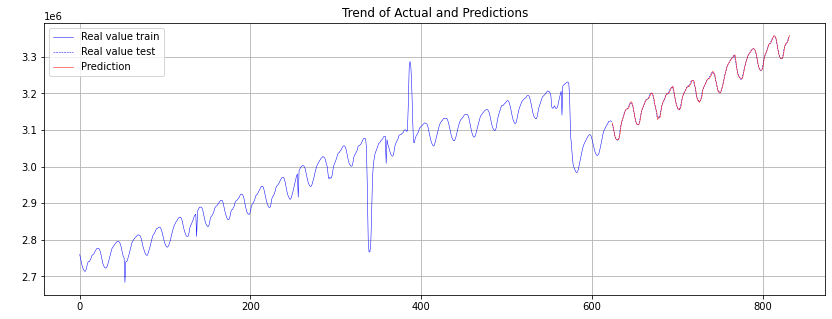

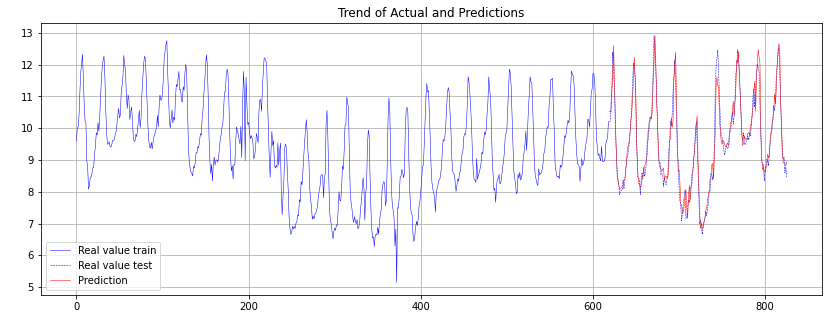

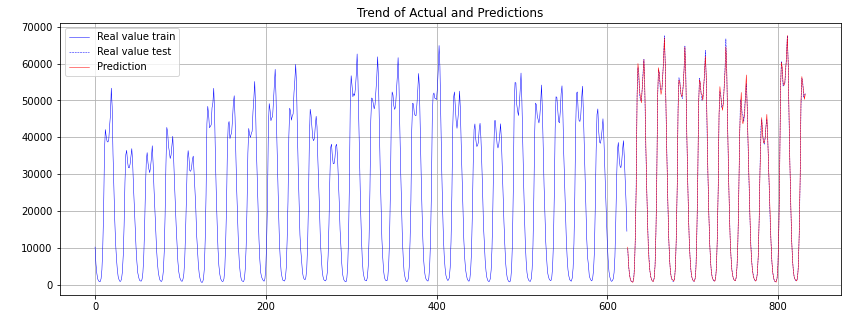

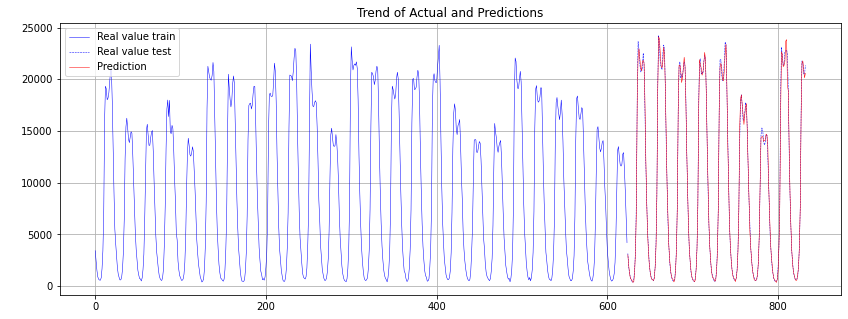

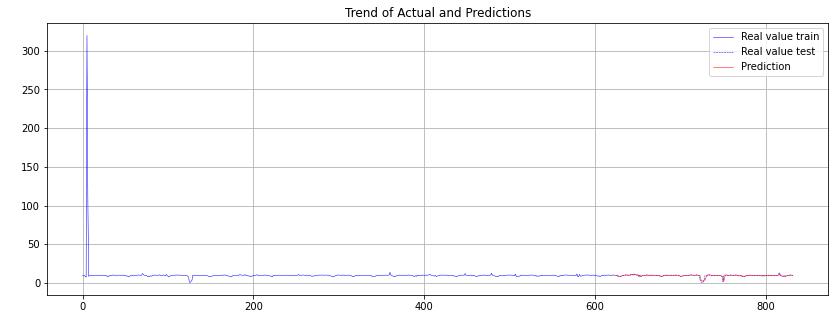

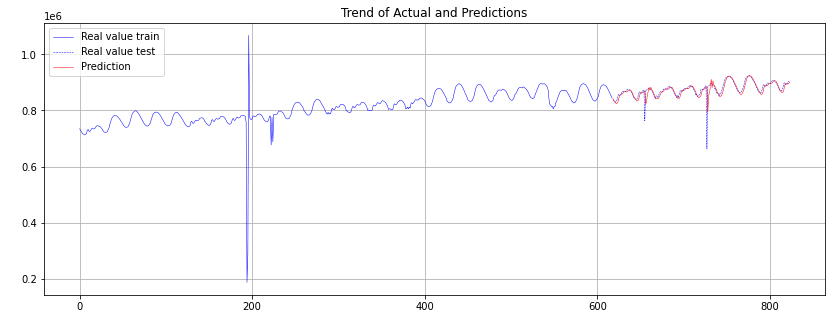

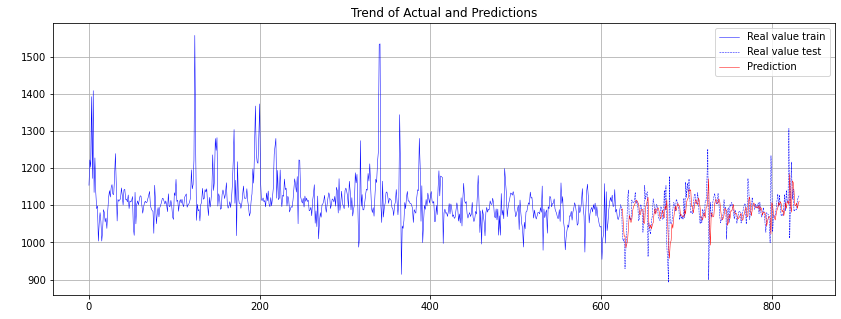

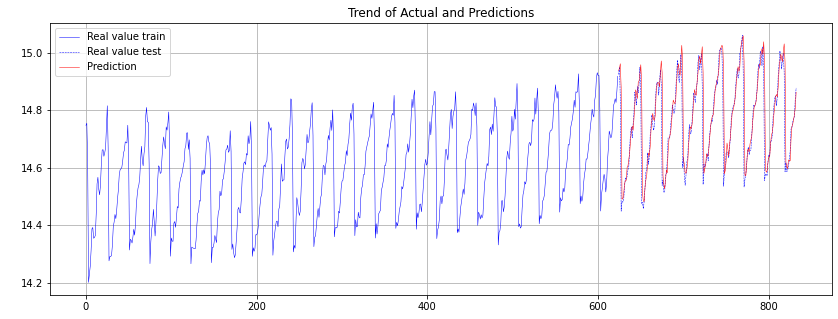

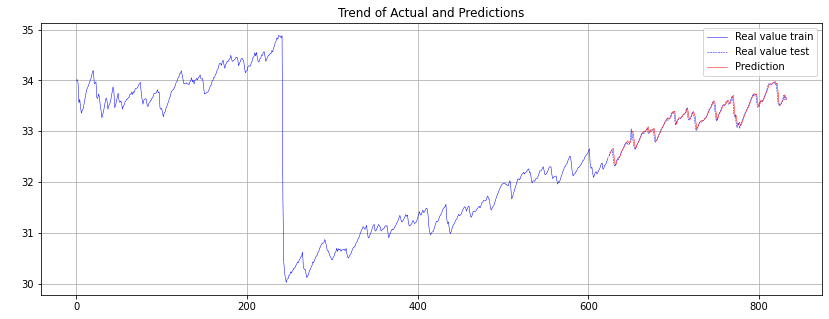

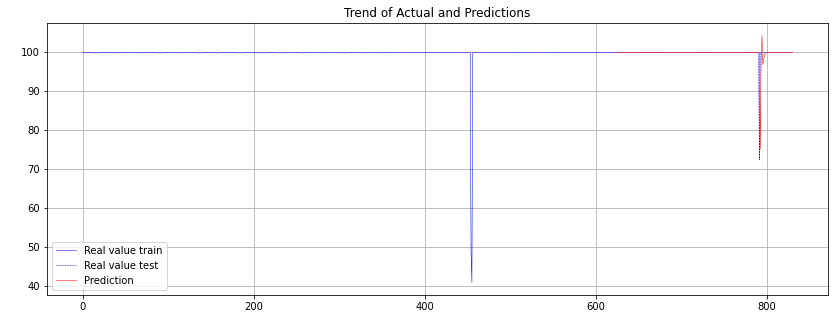

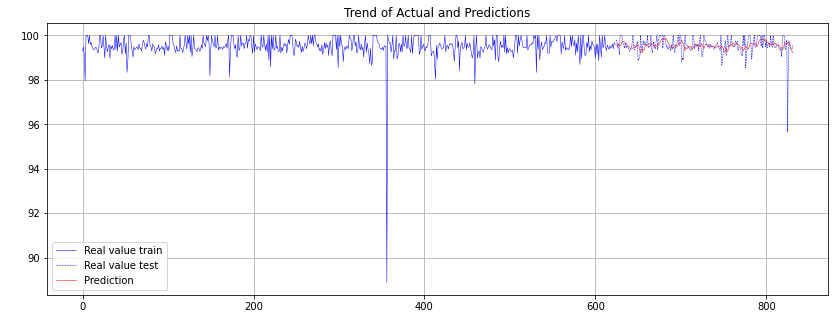

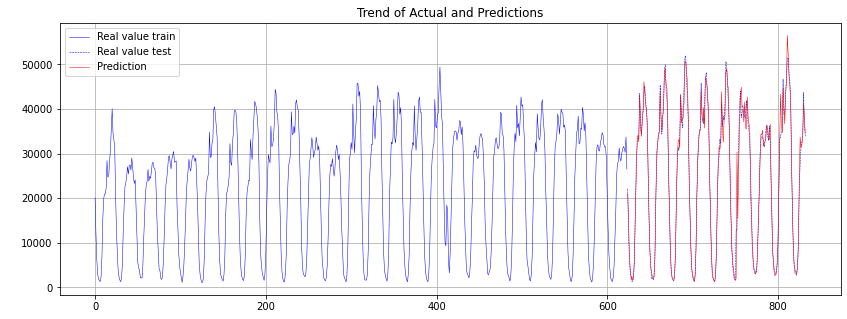

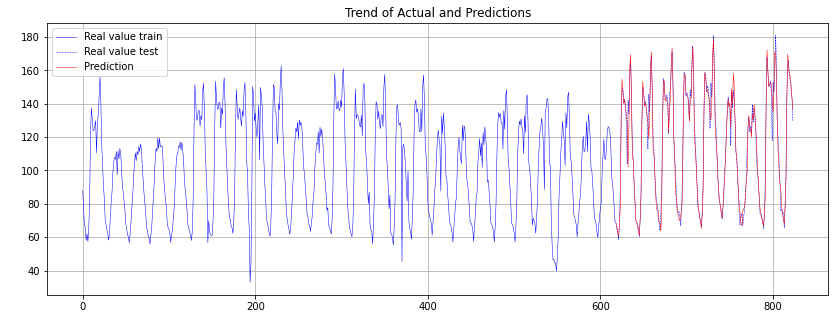

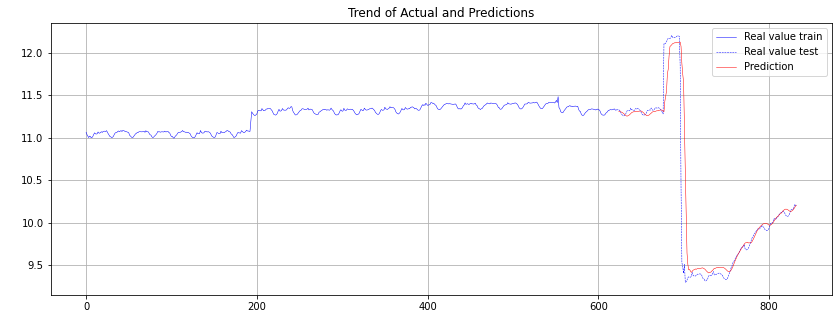

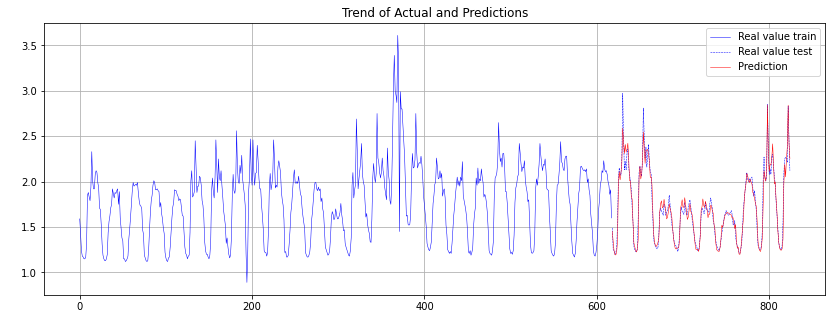

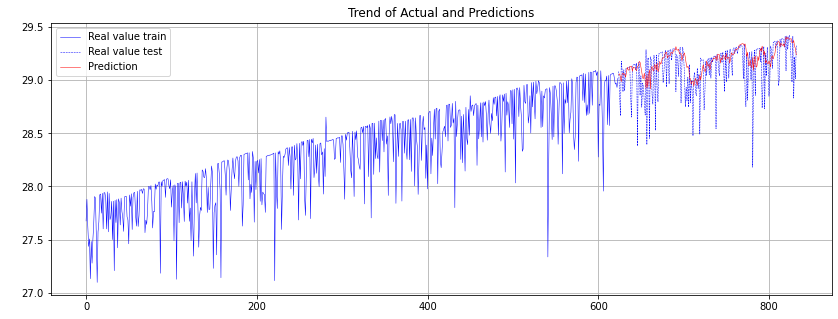

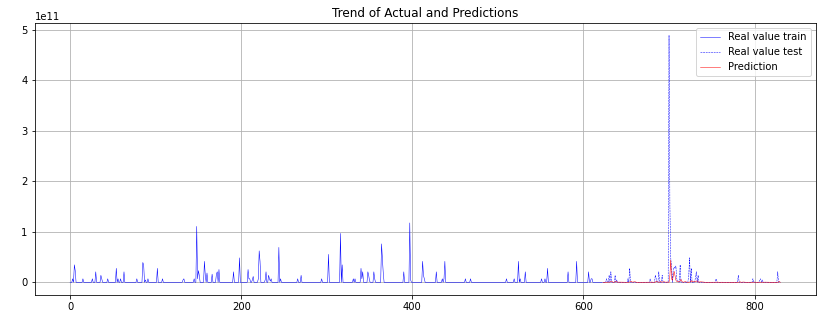

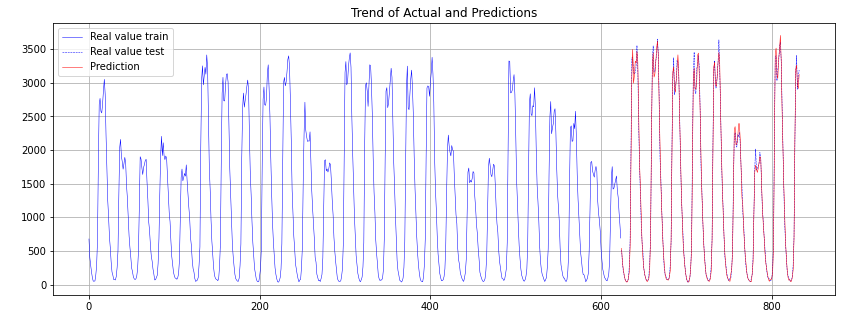

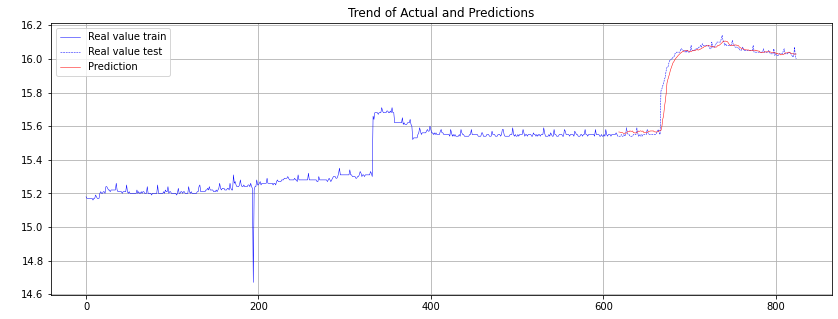

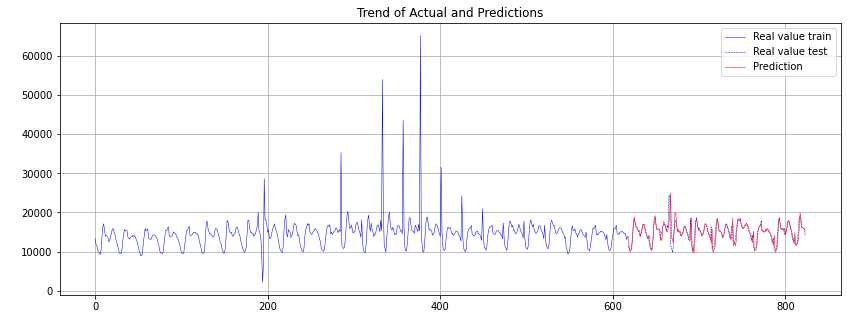

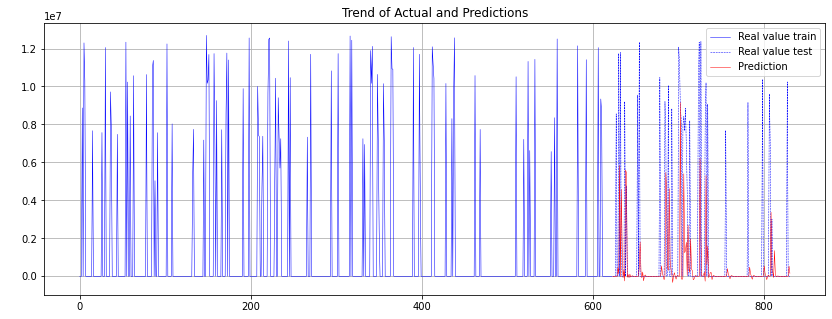

In [ ]:
%%time
score_dict = dict()
# import the dataset
for filename in range(50):
  df = pd.read_csv("/content/drive/MyDrive/gtmhub/dataset50/"+str(filename)+".csv", parse_dates = ['timestamp'], index_col = 'timestamp')
  # sort by dates
  df.sort_index(inplace = True)
  df.drop('Unnamed: 0',axis=1,inplace=True)

  """ALL OF THE STEPS ARE SAME AS BEFORE 
    EXCEPT STATEMENTS WITH ADDED COMMENTS"""
  # %%time
  revinlayer = RevIN()
  tf.random.set_seed(42)
  train_dataset,test_dataset,y_train,y_test = dataprep(df,WINDOW_SIZE)

  useRevIN=True
  nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  useRevIN=useRevIN,
                                  name="InitialBlock")

  stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")
  backcast, forecast = nbeats_block_layer(stack_input)
  residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

  if useRevIN==True:
    residuals = revinlayer(residuals, mode='norm') #residualts will be normalised using revin layer

  for i, _ in enumerate(range(N_STACKS-1)): 

    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals) 
    if useRevIN==True:
      residuals = revinlayer(residuals, mode='denorm') #denormalising the residuals with revin

    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

  nbeats_revin_model = tf.keras.Model(inputs=stack_input, 
                          outputs=forecast, 
                          name="model_N-BEATS_revin")

  nbeats_revin_model.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["mae", "mse"])

  nbeats_revin_model.fit(train_dataset,
              epochs=N_EPOCHS,
              validation_data=test_dataset,
              verbose=0,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


  nbeats_revin_model.evaluate(test_dataset)

  nbeats_revin_model_preds = make_preds(nbeats_revin_model, test_dataset)

  nbeats_revin_model_results = evaluate_preds(y_true=y_test,
                                  y_pred=nbeats_revin_model_preds)


  preds = pd.DataFrame(index = np.arange(len(y_train) + len(y_test)))
  preds['Real Value'] = np.hstack([y_train,y_test])
  preds['Prediction'] = np.hstack([y_train,nbeats_revin_model_preds])
  # and plot the predictions
  plt.figure(figsize=(14,5))
  plt.ylabel(' ')
  plt.title('Trend of Actual and Predictions')
  plt.plot(preds['Real Value'][:int(len(preds)*0.75)],color ='blue',linewidth=0.5)
  plt.plot(preds['Real Value'][int(len(preds)*0.75):],color ='blue',linestyle='dashed',linewidth=0.5)
  plt.plot(preds['Prediction'][int(len(preds)*0.75):],color='red',linewidth=0.5)
  # plt.axvline(x=int(len(preds['Prediction'])*0.75),color='brown',linestyle='dashed')
  plt.legend(['Real value train','Real value test','Prediction'])
  plt.grid(True)
  plt.savefig("/content/drive/MyDrive/gtmhub/plots/"+str(filename)+'.png')
  score=[]
  for i,j in nbeats_revin_model_results.items():
    score.append(i+':'+str(j))
  score_dict[str(filename)]= score
  print(score_dict)
  print(str(filename)+' '+'Done!!!')

In [ ]:
import json
with open('PATH_TO_SCORE_FILE', 'w') as score_file:
     score_file.write(json.dumps(score_dict))

# ONLY NBEATS

In [ ]:
#PARAMS
HORIZON = 1
WINDOW_SIZE = 7

# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4 # called "block layers" in Table 18
N_STACKS = 30 # called "stacks" in Table 18

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON


Epoch 170: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 362: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1272: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1372: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
1/1 [==============================] - 0s 22ms/step - loss: 0.0157 - mae: 0.0157 - mse: 4.0932e-04
{'0': ['mae:0.015679026', 'mse:0.00040932448', 'rmse:0.020231768', 'mape:0.032722607']}
0 Done!!!

Epoch 202: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 302: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 19ms/step - loss: 0.0105 - mae: 0.0105 - mse: 1.6971e-04
{'0': ['mae:0.015679026', 'mse:0.00040932448', 'rmse:0.020231768', 'mape:0.032722607'], '1': ['mae:0.010508158', 'mse:0.00016971033', 'rmse:0.013027292', 'mape:0.03687593']}
1 Done!!!

Epoch 185: ReduceLROnPlateau reducing

{'0': ['mae:0.015679026', 'mse:0.00040932448', 'rmse:0.020231768', 'mape:0.032722607'], '1': ['mae:0.010508158', 'mse:0.00016971033', 'rmse:0.013027292', 'mape:0.03687593'], '2': ['mae:0.05063609', 'mse:0.05599884', 'rmse:0.23664074', 'mape:0.115894966'], '3': ['mae:25.655844', 'mse:1695.0132', 'rmse:41.170536', 'mape:0.7474986'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0']}
4 Done!!!

Epoch 121: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 545: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 743: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 843: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
1/1 [==============================] - 0s 21ms/step - loss: 0.0154 - mae: 0.0154 - mse: 4.4519e-04


{'0': ['mae:0.015679026', 'mse:0.00040932448', 'rmse:0.020231768', 'mape:0.032722607'], '1': ['mae:0.010508158', 'mse:0.00016971033', 'rmse:0.013027292', 'mape:0.03687593'], '2': ['mae:0.05063609', 'mse:0.05599884', 'rmse:0.23664074', 'mape:0.115894966'], '3': ['mae:25.655844', 'mse:1695.0132', 'rmse:41.170536', 'mape:0.7474986'], '4': ['mae:0.0', 'mse:0.0', 'rmse:0.0', 'mape:0.0'], '5': ['mae:0.015393304', 'mse:0.0004451943', 'rmse:0.021099627', 'mape:0.36776572']}
5 Done!!!
CPU times: user 8min 1s, sys: 22.4 s, total: 8min 23s
Wall time: 8min 28s


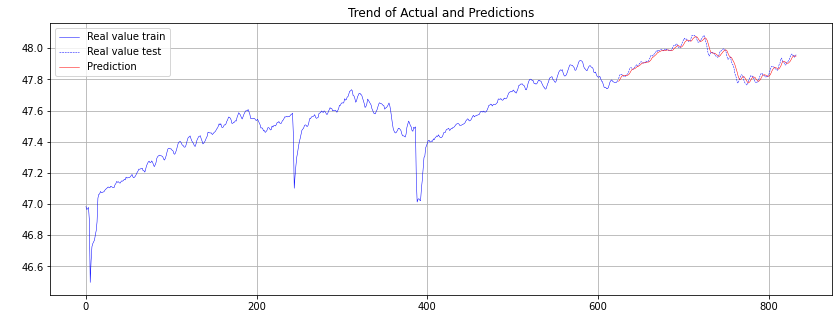

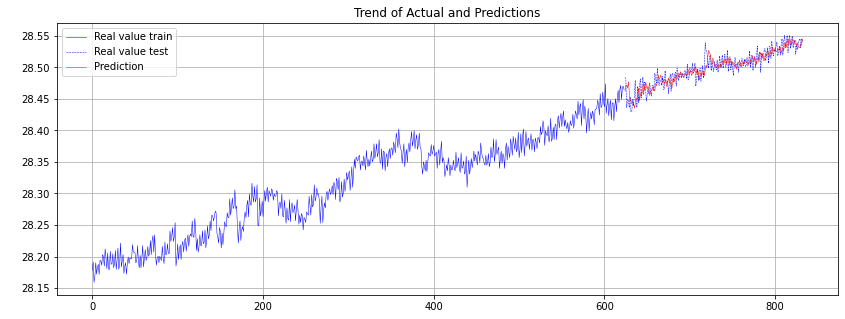

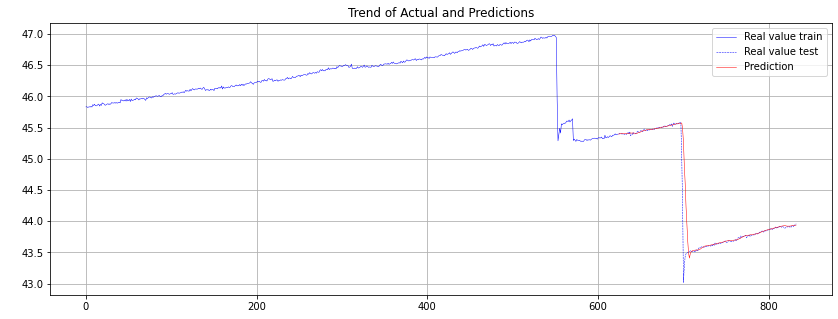

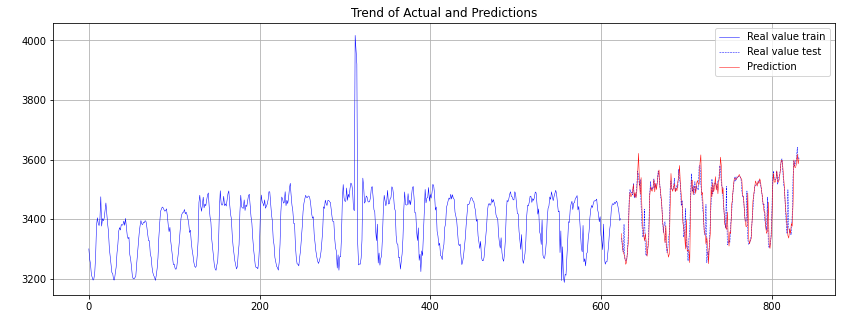

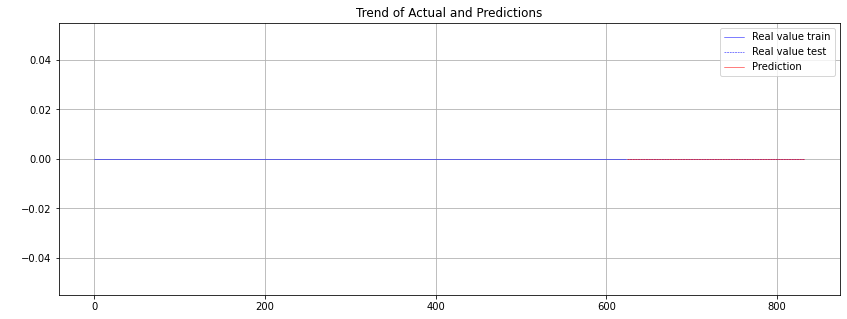

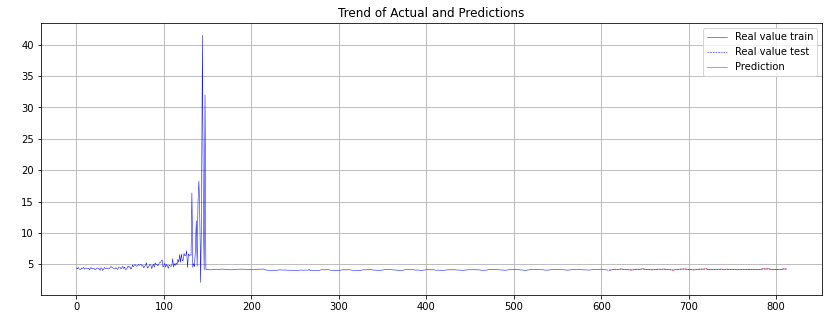

In [ ]:
%%time
score_dict = dict()
# import the dataset
for filename in range(6):
  df = pd.read_csv("/content/drive/MyDrive/gtmhub/dataset50/"+str(filename)+".csv", parse_dates = ['timestamp'], index_col = 'timestamp')
  # sort by dates
  df.sort_index(inplace = True)
  df.drop('Unnamed: 0',axis=1,inplace=True)

  """ALL OF THE STEPS ARE SAME AS BEFORE 
    EXCEPT STATEMENTS WITH ADDED COMMENTS"""
  # %%time
  # revinlayer = RevIN()
  tf.random.set_seed(42)
  train_dataset,test_dataset,y_train,y_test = dataprep(df,WINDOW_SIZE)

  useRevIN=False
  nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name="InitialBlock")

  stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")
  backcast, forecast = nbeats_block_layer(stack_input)
  residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

  # if useRevIN==True:
  #   residuals = revinlayer(residuals, mode='norm') #residualts will be normalised using revin layer

  for i, _ in enumerate(range(N_STACKS-1)): 

    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals) 
    # if useRevIN==True:
    #   residuals = revinlayer(residuals, mode='denorm') #denormalising the residuals with revin

    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

  nbeats_model = tf.keras.Model(inputs=stack_input, 
                          outputs=forecast, 
                          name="model_N-BEATS")

  nbeats_model.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["mae", "mse"])

  nbeats_model.fit(train_dataset,
              epochs=N_EPOCHS,
              validation_data=test_dataset,
              verbose=0,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


  nbeats_model.evaluate(test_dataset)

  nbeats_model_preds = make_preds(nbeats_model, test_dataset)

  nbeats_model_results = evaluate_preds(y_true=y_test,
                                  y_pred=nbeats_model_preds)


  preds = pd.DataFrame(index = np.arange(len(y_train) + len(y_test)))
  preds['Real Value'] = np.hstack([y_train,y_test])
  preds['Prediction'] = np.hstack([y_train,nbeats_model_preds])
  # and plot the predictions
  plt.figure(figsize=(14,5))
  plt.ylabel(' ')
  plt.title('Trend of Actual and Predictions')
  plt.plot(preds['Real Value'][:int(len(preds)*0.75)],color ='blue',linewidth=0.5)
  plt.plot(preds['Real Value'][int(len(preds)*0.75):],color ='blue',linestyle='dashed',linewidth=0.5)
  plt.plot(preds['Prediction'][int(len(preds)*0.75):],color='red',linewidth=0.5)
  # plt.axvline(x=int(len(preds['Prediction'])*0.75),color='brown',linestyle='dashed')
  plt.legend(['Real value train','Real value test','Prediction'])
  plt.grid(True)
  plt.savefig("/content/drive/MyDrive/gtmhub/plots4/"+str(filename)+'.png')
  score=[]
  for i,j in nbeats_model_results.items():
    score.append(i+':'+str(j))
  score_dict[str(filename)]= score
  print(score_dict)
  print(str(filename)+' '+'Done!!!')
# f = open('/content/drive/MyDrive/gtmhub/score.txt','w')
# f.write(nbeats_model_results)

# PROPHET

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# %%time
# score_dict = dict()
# for filename in range(50):
filename=6
df = pd.read_csv("/content/drive/MyDrive/gtmhub/dataset50/"+str(filename)+".csv", parse_dates = ['timestamp'])
df.sort_index(inplace = True)
df.drop('Unnamed: 0',axis=1,inplace=True)
df['ds']= df['timestamp']
df['y'] = df['value']
df.drop('timestamp',axis=1,inplace=True)
df.drop('value',axis=1,inplace=True)
df['ds'] = pd.to_datetime(df['ds'], unit='s')

m = Prophet()
m.fit(df[:int(len(df)*0.75)])

future = m.make_future_dataframe(periods=int(len(df)*0.25))

forecast = m.predict(future)

res = evaluate_preds(df['y'].to_numpy(),forecast['yhat'].to_numpy())

preds = pd.DataFrame(index = np.arange(len(df['y'])))
preds['Real Value'] = np.hstack([df['y'].to_numpy()])
preds['Prediction'] = np.hstack([forecast['yhat'].to_numpy()])
plt.figure(figsize=(17,4))
plt.ylabel(' ')
plt.title('Trend of Actual and Predictions')
plt.plot(preds['Real Value'][:int(len(preds)*0.75)],color ='blue',linewidth=0.5)
plt.plot(preds['Real Value'][int(len(preds)*0.75):],color ='blue',linestyle='dashed',linewidth=0.5)
plt.plot(preds['Prediction'][int(len(preds)*0.75):],color='red',linewidth=0.5)
plt.legend(['Real value train','Real value test','Prediction'])
plt.grid(True)
plt.savefig("/content/drive/MyDrive/gtmhub/plots2/"+str(filename)+'.png')

score=[]
for i,j in res.items():
  score.append(i+':'+str(j))
score_dict[str(filename)]= score
print(score_dict)
print(str(filename)+' '+'Done!!!')